In [275]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import os
import time
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates


In [2]:
# Get the fred api key
load_dotenv("keys.env")
fred_api_key = os.getenv("FRED_API_KEY")

# Retrieve FRED Data
### Federal Reserve Economic Data (FRED)
##### Maintained by Federal Reserve Bank of St. Louis 

In [437]:
# Store FRED data in a dictionary
df_dict = {"income_adjusted": "MEPAINUSA672N", "house": "NCSTHPI", "house_cpi": "CPIHOSSL", "minimum_wage": "STTMINWGNC", "rent_cpi": "CUUR0000SEHA", "mortgage": "MORTGAGE30US", "population": "NCPOP", "electricity": "APU000072610", "car_cpi": "CUSR0000SETA01", "gas": "APU000074714"}

for key, value in df_dict.items():
    try:
        data = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id={value}&api_key={fred_api_key}&file_type=json").json()
        df = pd.DataFrame(data['observations'])
        df_dict[key] = df
    except:
        print(f"Problem getting data for {key}: {value}")


# Clean up Data from FRED
## Store the data as csv files in data folder

In [438]:
# Read the CSV files, and store dataframes. Some clean up as well.
def percent_change_column(df):
    """Create a column that shows how much the value has changed overtime"""
    df['changed'] = (df['value'].pct_change() * 100).cumsum().fillna(0)
    return df

def locate_year_df(df):
    """Take a df and return the dataframe within the year 1980-2023"""
    df = df.loc[(df['date'] >= "1980-01-01") & (df['date'] <= "2023-12-31")].reset_index(drop=True)
    return df

def conversion_date_value(df):
    """Convert the columns date to datetime and value to float"""
    conversions = {
    'date': 'datetime64[ns]',
    'value': float
    }

    # Drop any rows where the value column is non numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df = df.drop(columns=['realtime_start', 'realtime_end']).astype(conversions)
    return df

# Clean the data and store them as a csv file in the data folder.
data_dict = {}
for key, value in df_dict.items():
    df_key = f"{key}_df"
    try:
        data_dict[(df_key)] = percent_change_column(locate_year_df(conversion_date_value(value)))

        data_dict[df_key].to_csv(f"data/{key}.csv")
    except:
        print(f"Error with {key} dataset.")


/var/folders/kh/3tw2vndj0gj3w6nlrv1mggtc0000gn/T/ipykernel_91770/1689987472.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['changed'] = (df['value'].pct_change() * 100).cumsum().fillna(0)
/var/folders/kh/3tw2vndj0gj3w6nlrv1mggtc0000gn/T/ipykernel_91770/1689987472.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['changed'] = (df['value'].pct_change() * 100).cumsum().fillna(0)


# Display FRED Data

In [439]:
# Display the DataFrames first 2 and last 2 rows
for key, value in data_dict.items():
    clean_key = key.replace("_", " ")
    print(clean_key)
    display(pd.concat([value.head(2), value.tail(2)]))

income adjusted df


,date,value,changed
0,1980-01-01,25380.0,0.000000
1,1981-01-01,24880.0,-1.970055
41,2021-01-01,40460.0,47.762599
42,2022-01-01,40480.0,47.812030


house df


,date,value,changed
0,1980-01-01,100.00,0.000000
1,1980-04-01,98.91,-1.090000
174,2023-07-01,650.12,189.850435
175,2023-10-01,649.30,189.724304


house cpi df


,date,value,changed
0,1980-01-01,76.200,0.000000
1,1980-02-01,77.200,1.312336
526,2023-11-01,325.428,145.553847
527,2023-12-01,326.409,145.855296


minimum wage df


,date,value,changed
0,1980-01-01,2.75,0.000000
1,1981-01-01,2.90,5.454545
42,2022-01-01,7.25,104.031762
43,2023-01-01,7.25,104.031762


rent cpi df


,date,value,changed
0,1980-01-01,77.800,0.000000
1,1980-02-01,78.400,0.771208
526,2023-11-01,408.838,166.273353
527,2023-12-01,410.606,166.705799


mortgage df


,date,value,changed
0,1980-01-04,12.85,0.000000
1,1980-01-11,12.90,0.389105
2323,2023-12-21,6.67,-33.422587
2324,2023-12-28,6.61,-34.322137


population df


,date,value,changed
0,1980-01-01,5898.980,0.000000
1,1981-01-01,5956.653,0.977677
42,2022-01-01,10695.965,60.060587
43,2023-01-01,10835.491,61.365060


electricity df


,date,value,changed
0,1980-01-01,0.053,0.000000
1,1980-02-01,0.055,3.773585
526,2023-11-01,0.168,130.033561
527,2023-12-01,0.169,130.628799


car cpi df


,date,value,changed
0,1980-01-01,85.200,0.000000
1,1980-02-01,86.300,1.291080
526,2023-11-01,179.222,74.794595
527,2023-12-01,179.551,74.978166


gas df


,date,value,changed
0,1980-01-01,1.131,0.000000
1,1980-02-01,1.207,6.719717
526,2023-11-01,3.500,187.021941
527,2023-12-01,3.289,180.993370


# Plot the changed column for all of the datasets
## Shows how much the data has changed overtime

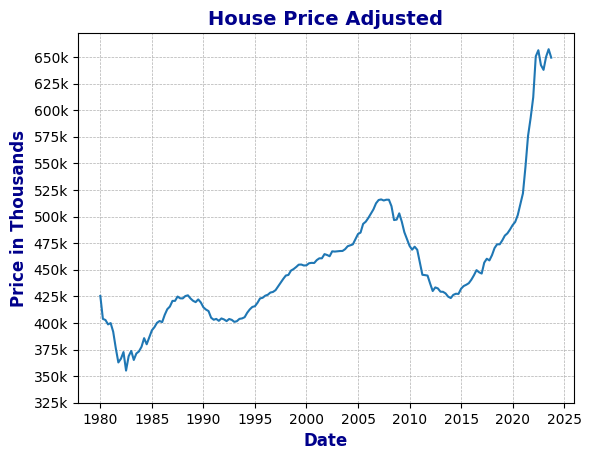

In [455]:
# Function to format y-axis labels with 'k' and 'm'
def format_y(value, tick_position):

    return f'{value}k'

# Adjusting house price with inflation

inflation_house = pd.merge(data_dict['house_df'], data_dict['house_cpi_df'], on='date')
inflation_house = inflation_house.drop(columns=['changed_x', 'changed_y'])
inflation_house.columns = ['date', 'price', 'cpi']
inflation_house['adjusted_price'] = (324.152/inflation_house['cpi']) * inflation_house['price']



plt.plot(inflation_house['date'], inflation_house['adjusted_price'])
plt.title("House Price Adjusted", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(325, 675, 25))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.savefig("graphs/house_price_adjusted.png")
plt.show()

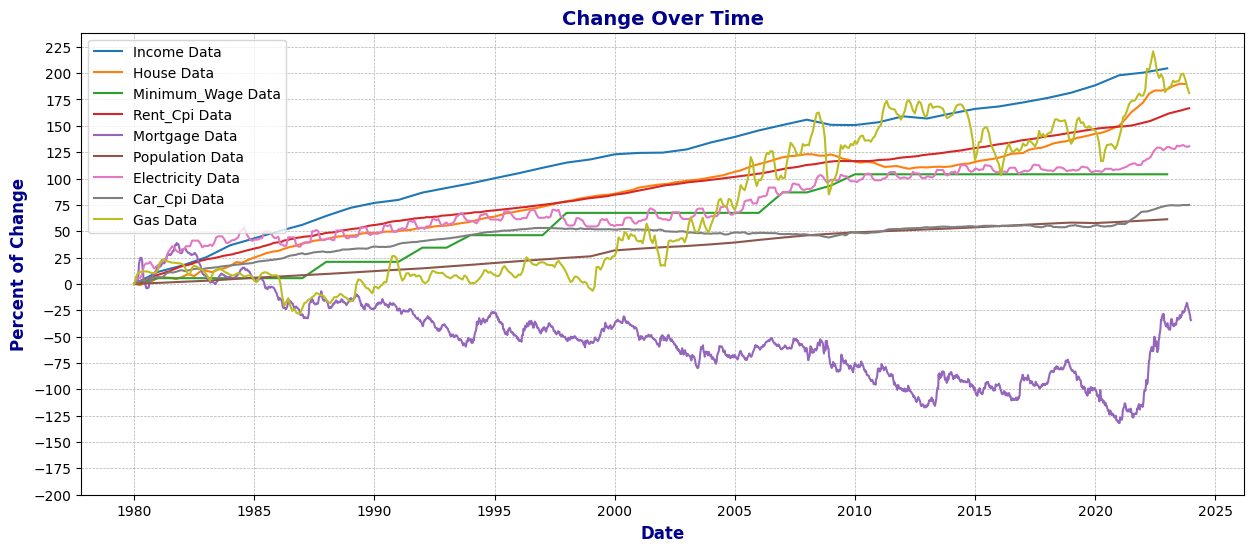

In [357]:
# Creating a visualization for income data
# Assuming df_income, df_house, and df_min_wage are your DataFrames
plt.figure(figsize=(15, 6))

# Plot each DataFrame
for key, value in data_dict.items():
    plt.plot(value['date'], value['changed'], label=f'{key.replace("_df", "").title()} Data')

plt.title("Change Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Percent of Change", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.legend()
plt.yticks(range(-200, 250, 25))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/change_over_time.png')
plt.show()


# Plot All of the Graphs

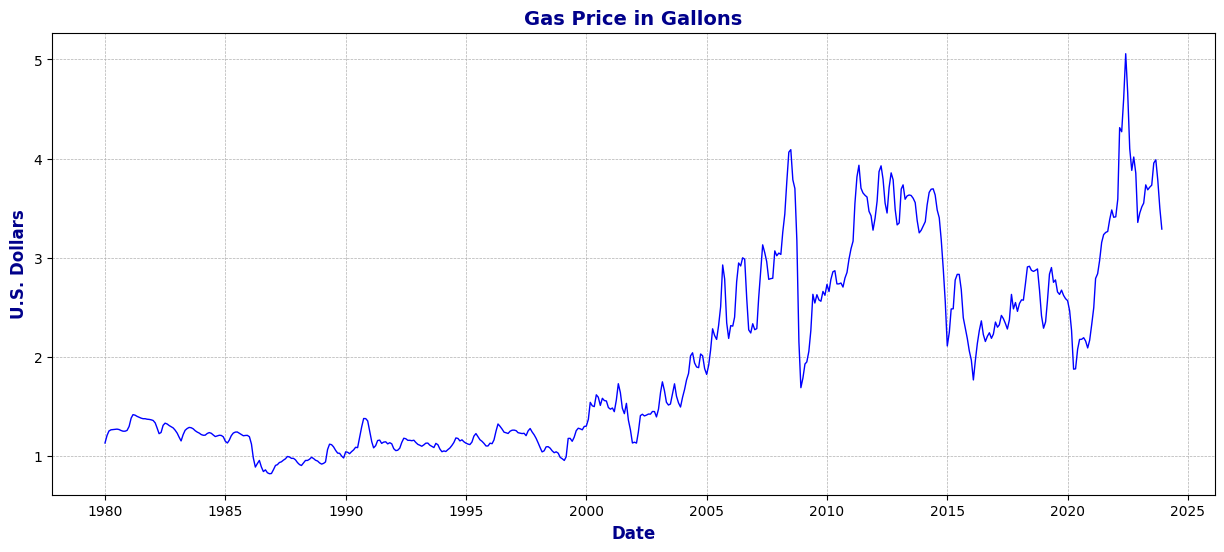

,date,value,changed
0,1980-01-01,1.131,0.000000
1,1980-02-01,1.207,6.719717
2,1980-03-01,1.252,10.447969
3,1980-04-01,1.264,11.406435
4,1980-05-01,1.266,11.564663
...,...,...,...
523,2023-08-01,3.955,198.809423
524,2023-09-01,3.988,199.643810
525,2023-10-01,3.782,194.478313
526,2023-11-01,3.500,187.021941


In [362]:
plt.figure(figsize=(15, 6))
plt.plot(data_dict['gas_df']['date'], data_dict['gas_df']['value'], linewidth=1, linestyle='-', color='blue')

plt.title("Gas Price in Gallons", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("U.S. Dollars", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/gas_price.png')
plt.show()
data_dict['gas_df']

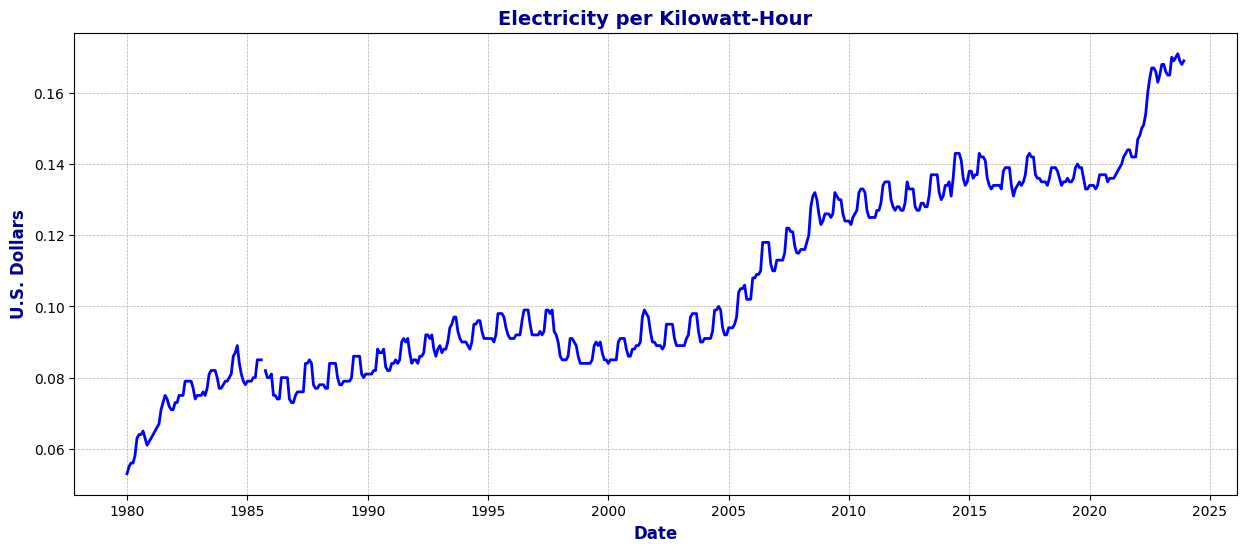

,date,value,changed
0,1980-01-01,0.053,0.000000
1,1980-02-01,0.055,3.773585
2,1980-03-01,0.056,5.591767
3,1980-04-01,0.056,5.591767
4,1980-05-01,0.058,9.163195
...,...,...,...
523,2023-08-01,0.170,131.206632
524,2023-09-01,0.171,131.794867
525,2023-10-01,0.169,130.625277
526,2023-11-01,0.168,130.033561


In [363]:
plt.figure(figsize=(15, 6))
plt.plot(data_dict['electricity_df']['date'], data_dict['electricity_df']['value'], linewidth=2, linestyle='-', color='blue')

plt.title("Electricity per Kilowatt-Hour", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("U.S. Dollars", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/electricity_price.png')
plt.show()
data_dict['electricity_df']

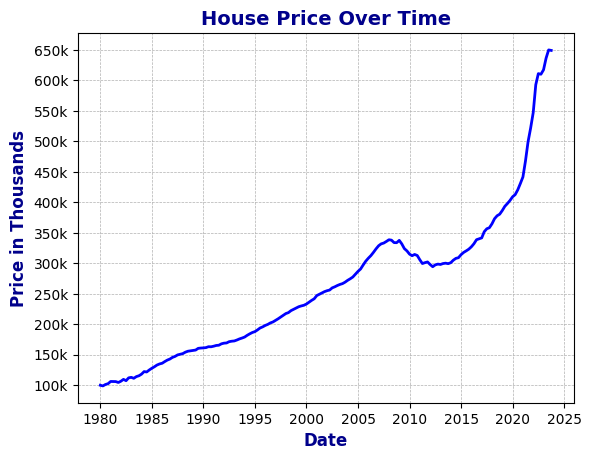

,date,value,changed
0,1980-01-01,100.00,0.000000
1,1980-04-01,98.91,-1.090000
2,1980-07-01,101.26,1.285897
3,1980-10-01,102.56,2.569721
4,1981-01-01,106.21,6.128613
...,...,...,...
171,2022-10-01,610.23,183.442224
172,2023-01-01,617.47,184.628662
173,2023-04-01,636.51,187.712212
174,2023-07-01,650.12,189.850435


In [364]:

plt.plot(data_dict['house_df']['date'], data_dict['house_df']['value'], linewidth=2, linestyle='-', color='blue')


plt.title("House Price Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.yticks(range(100, 700, 50))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/house_price_over_time.png')
plt.show()
data_dict['house_df']

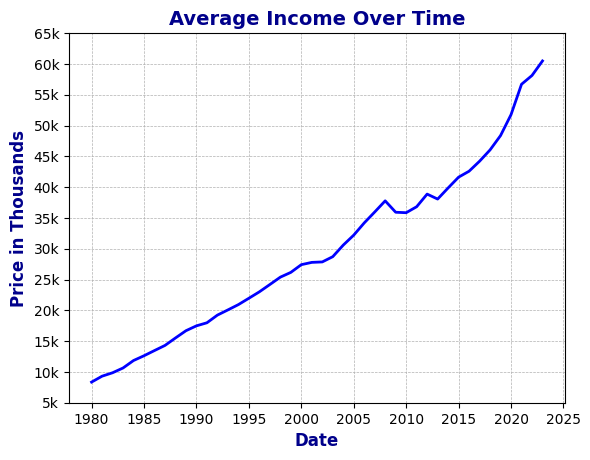

,date,value,changed
0,1980-01-01,8350.0,0.000000
1,1981-01-01,9309.0,11.485030
2,1982-01-01,9864.0,17.447002
3,1983-01-01,10639.0,25.303855
4,1984-01-01,11850.0,36.686504
5,1985-01-01,12628.0,43.251905
6,1986-01-01,13470.0,49.919628
7,1987-01-01,14301.0,56.088893
8,1988-01-01,15510.0,64.542847
9,1989-01-01,16692.0,72.163737


In [365]:
plt.plot(data_dict['income_df']['date'], (data_dict['income_df']['value']/1000), linewidth=2, linestyle='-', color='blue')

plt.title("Average Income Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.yticks(range(5, 70, 5))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/income_over_time.png')
plt.show()
data_dict['income_df']

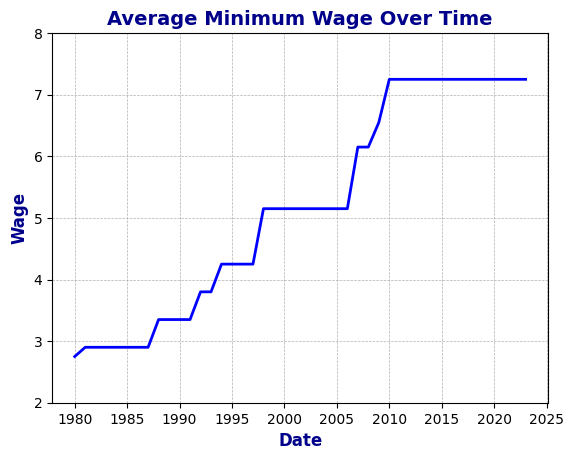

,date,value,changed
0,1980-01-01,2.75,0.000000
1,1981-01-01,2.90,5.454545
2,1982-01-01,2.90,5.454545
3,1983-01-01,2.90,5.454545
4,1984-01-01,2.90,5.454545
5,1985-01-01,2.90,5.454545
6,1986-01-01,2.90,5.454545
7,1987-01-01,2.90,5.454545
8,1988-01-01,3.35,20.971787
9,1989-01-01,3.35,20.971787


In [366]:
plt.plot(data_dict['minimum_wage_df']['date'], (data_dict['minimum_wage_df']['value']), linewidth=2, linestyle='-', color='blue')

plt.title("Average Minimum Wage Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Wage", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(2, 9, 1))
plt.savefig('graphs/min_wage_over_time.png')
plt.show()
data_dict['minimum_wage_df']

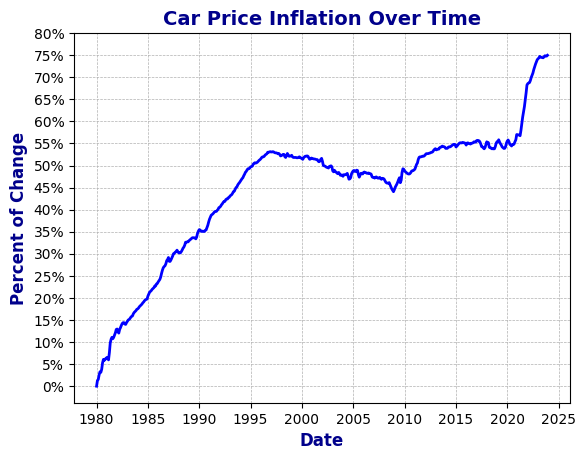

In [341]:
# Plot the CPI data for cars
plt.plot(data_dict['car_cpi_df']['date'], (data_dict['car_cpi_df']['changed']), linewidth=2, linestyle='-', color='blue')

plt.title("Car Price Inflation Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Percent of Change", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(0, 85, 5))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

,date,value,changed,price
0,1980-01-01,85.200,0.000000,22776.815501
1,1980-02-01,86.300,1.291080,23070.882368
2,1980-03-01,86.500,1.522830,23124.349071
3,1980-04-01,87.400,2.563292,23364.949234
4,1980-05-01,88.000,3.249791,23525.349344
...,...,...,...,...
523,2023-08-01,178.927,74.629544,47833.183886
524,2023-09-01,179.361,74.872101,47949.206632
525,2023-10-01,179.247,74.808542,47918.730611
526,2023-11-01,179.222,74.794595,47912.047273


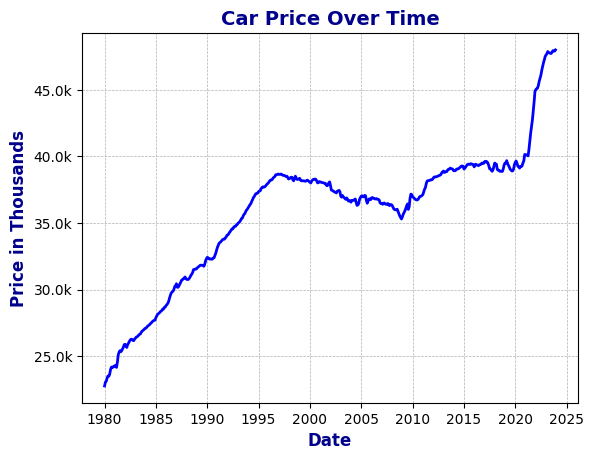

In [351]:
car_cpi = data_dict['car_cpi_df']
car_cpi['price'] = (car_cpi['value']/179.551) *48000
display(car_cpi)
plt.plot(car_cpi['date'], car_cpi['price']/1000, linewidth=2, linestyle='-', color='blue')

plt.title("Car Price Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.savefig('graphs/car_price.png')
plt.show()

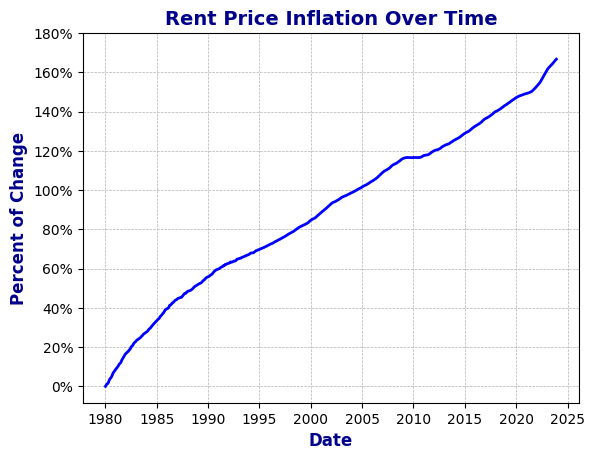

In [369]:
plt.plot(data_dict['rent_cpi_df']['date'], (data_dict['rent_cpi_df']['changed']), linewidth=2, linestyle='-', color='blue')

plt.title("Rent Price Inflation Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Percent of Change", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(0, 200, 20))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

,date,value,changed,price
0,1980-01-01,77.800,0.000000,255.792658
1,1980-02-01,78.400,0.771208,257.765352
2,1980-03-01,78.800,1.281412,259.080481
3,1980-04-01,79.000,1.535219,259.738046
4,1980-05-01,79.800,2.547878,262.368304
...,...,...,...,...
523,2023-08-01,402.247,164.643675,1322.517085
524,2023-09-01,404.487,165.200547,1329.881809
525,2023-10-01,406.683,165.743457,1337.101869
526,2023-11-01,408.838,166.273353,1344.187128


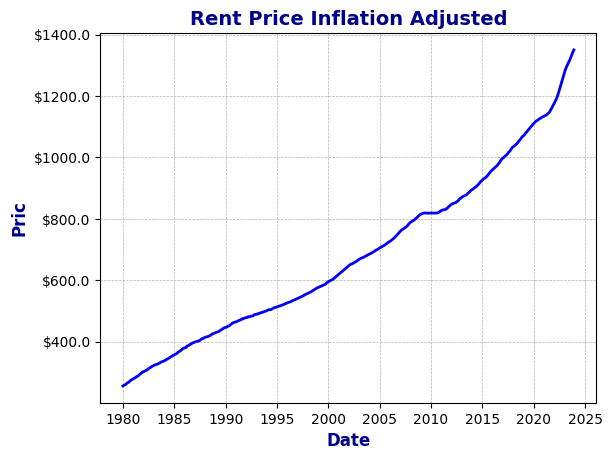

In [368]:
def format_dollar(value, tick_position):
    return f'${value}'

rent_cpi = data_dict['rent_cpi_df']
rent_cpi['price'] = (rent_cpi['value']/410.606) * 1350
display(rent_cpi)
plt.plot(rent_cpi['date'], rent_cpi['price'], linewidth=2, linestyle='-', color='blue')

plt.title("Rent Price Inflation Adjusted", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Pric", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_dollar))
plt.savefig('graphs/rent_price.png')
plt.show()

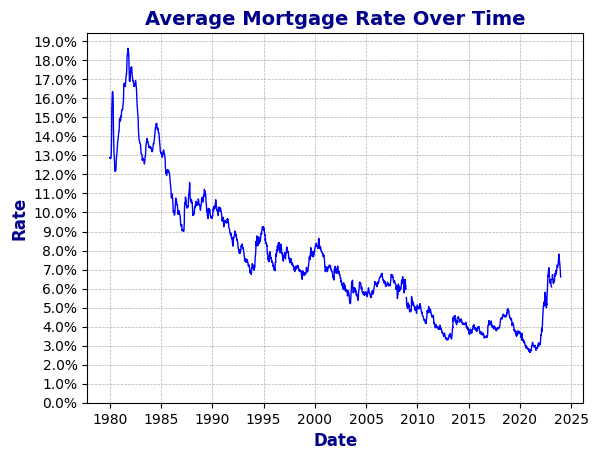

,date,value,changed
0,1980-01-04,12.85,0.000000
1,1980-01-11,12.90,0.389105
2,1980-01-18,12.87,0.156547
3,1980-01-25,12.89,0.311947
4,1980-02-01,12.85,0.001629
...,...,...,...
2320,2023-11-30,7.22,-25.624251
2321,2023-12-07,7.03,-28.255830
2322,2023-12-14,6.95,-29.393810
2323,2023-12-21,6.67,-33.422587


In [370]:
plt.plot(data_dict['mortgage_df']['date'], (data_dict['mortgage_df']['value']), linewidth=1, linestyle='-', color='blue')

plt.title("Average Mortgage Rate Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Rate", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(0, 20, 1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('graphs/mortgage_rate_over_time.png')
plt.show()
data_dict['mortgage_df']

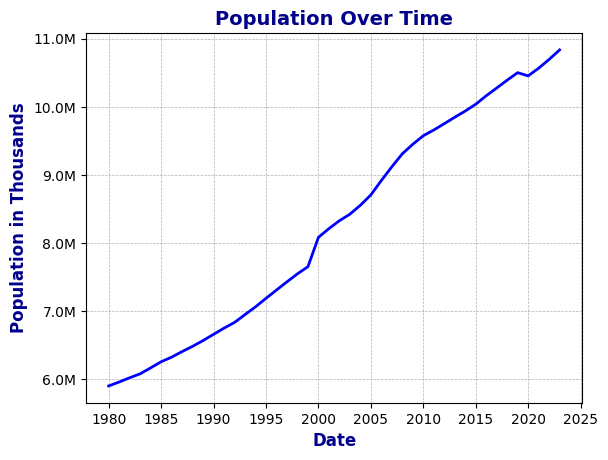

,date,value,changed
0,1980-01-01,5898.980,0.000000
1,1981-01-01,5956.653,0.977677
2,1982-01-01,6019.101,2.026051
3,1983-01-01,6077.056,2.988903
4,1984-01-01,6164.006,4.419694
5,1985-01-01,6253.954,5.878940
6,1986-01-01,6321.578,6.960240
7,1987-01-01,6403.700,8.259315
8,1988-01-01,6480.594,9.460089
9,1989-01-01,6565.459,10.769614


In [383]:
def format_m(value, tick_position):
    return f"{value}.0M"

plt.plot(data_dict['population_df']['date'], (data_dict['population_df']['value']/1000), linewidth=2, linestyle='-', color='blue')

plt.title("Population Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Population in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(6, 12, 1))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_m))
plt.savefig('graphs/population_over_time.png')
plt.show()
data_dict['population_df']

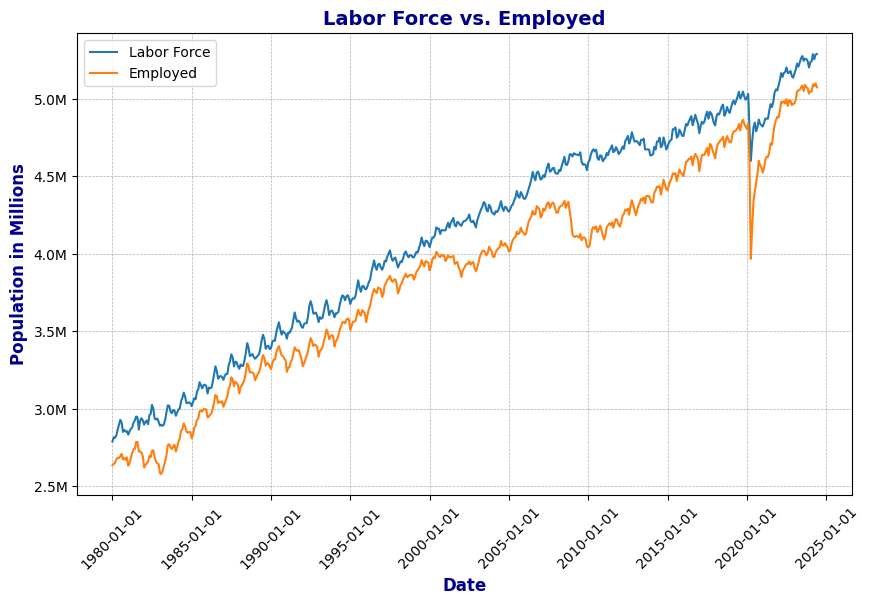

In [87]:
def format_m(value, tick_position):
    return f"{value/1000000}M"

unemployment = pd.read_csv("data/unemployment_rate.csv", index_col=0)
unemployment["Date"] = unemployment['Date'].astype("datetime64[ns]")
plt.figure(figsize=(10, 6))

plt.plot(unemployment['Date'], unemployment['Labor Force'], label="Labor Force")
plt.plot(unemployment['Date'], unemployment['Employed'], label="Employed")


plt.title("Labor Force vs. Employed", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Population in Millions", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

#
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_m))
plt.xticks(pd.date_range(start=pd.Timestamp('1980-01-01'),
                         end=pd.Timestamp('2025-01-01'),
                         freq='5YS'), rotation=45)
plt.legend()
plt.savefig("graphs/labor_force_employed.png")
plt.show()

# House Price Affordability Index
- Goal: Create an index that tracks housing affordability over time.
- Graph Type: Composite Line Chart
- Description: Plot a line chart where you calculate an affordability index based on the ratio of income to house prices. You can overlay this with mortgage rates to see how they impact affordability.
- Use Case: This index will highlight periods where housing became more or less affordable relative to income.

,date,value_h,changed_h,value_i,changed_i,affordability
0,1980-01-01,100.00,0.000000,8350.0,0.000000,0.011976
1,1981-01-01,106.21,6.128613,9309.0,11.485030,0.011409
2,1982-01-01,106.69,6.609981,9864.0,17.447002,0.010816
3,1983-01-01,112.97,12.480768,10639.0,25.303855,0.010618
4,1984-01-01,118.25,17.121982,11850.0,36.686504,0.009979


[]

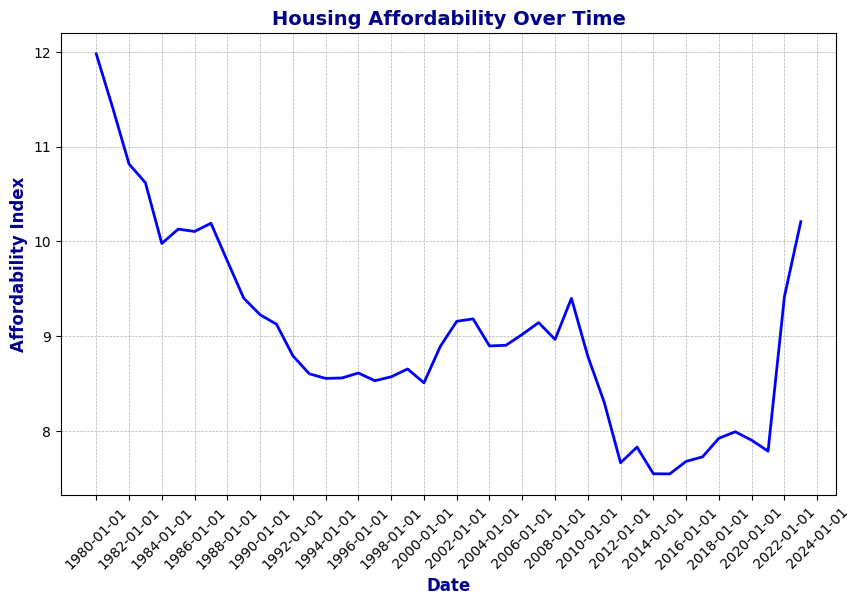

In [121]:
house_df = pd.read_csv("data/house.csv", index_col=0)
income_df = pd.read_csv("data/income.csv", index_col=0)

house_income_df = pd.merge(house_df, income_df, on='date', suffixes=('_h', '_i'))
house_income_df['affordability'] = house_income_df['value_h']/ house_income_df['value_i']
house_income_df['date'] = house_income_df['date'].astype("datetime64[ns]")

display(house_income_df.head())
plt.figure(figsize=(10, 6))

plt.plot(house_income_df['date'], house_income_df['affordability']*1000, linewidth=2, linestyle='-', color='blue')
plt.title("Housing Affordability Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Affordability Index", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(pd.date_range(start=pd.Timestamp('1980-01-01'),
                         end=pd.Timestamp('2025-01-01'),
                         freq='2YS'), rotation=45)
plt.savefig("graphs/housing_affordabilty.png")
plt.plot()

# Correlation Analysis
- Goal: Investigate relationships between different economic indicators.
- Graph Type: Correlation Matrix / Heatmap
- Description: Create a heatmap that shows the correlation coefficients between different pairs of indicators (e.g., income vs. house prices, minimum wage vs. CPI). This will help identify any strong positive or negative correlations.
- Use Case: Useful for understanding the degree to which one variable might influence another.

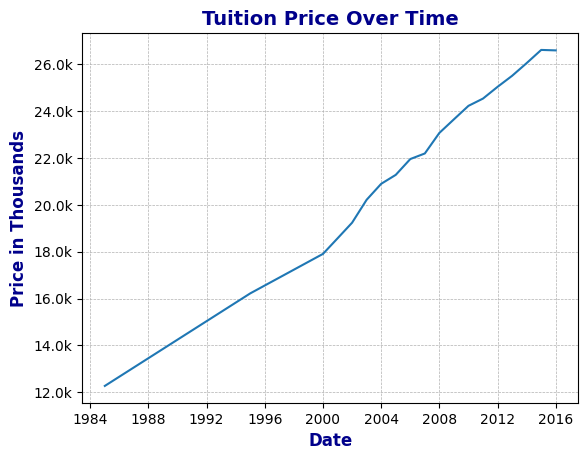

In [234]:
population_csv = pd.read_csv("data/population.csv")
mortgage_csv = pd.read_csv("data/mortgage.csv")
cpi_csv = pd.read_csv("data/cpi.csv", index_col=0)
minimum_wage_csv = pd.read_csv("data/minimum_wage.csv")
historical_tuition_csv = pd.read_csv("data/historical_tuition.csv")

historical_tuition_csv['year'] = pd.to_datetime((historical_tuition_csv['year'].str[:4]), format='%Y')
historical_tuition_csv = historical_tuition_csv.loc[(historical_tuition_csv['tuition_type'] == "4 Year Constant") & (historical_tuition_csv['type'] == "All Institutions")].reset_index(drop=True)
historical_tuition_csv.drop(columns=['tuition_type', 'type'], inplace=True)

plt.plot(historical_tuition_csv['year'], historical_tuition_csv['tuition_cost']/1000)

plt.title("Tuition Price Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("graphs/tuition_price_over_time.png")
plt.show()

[]

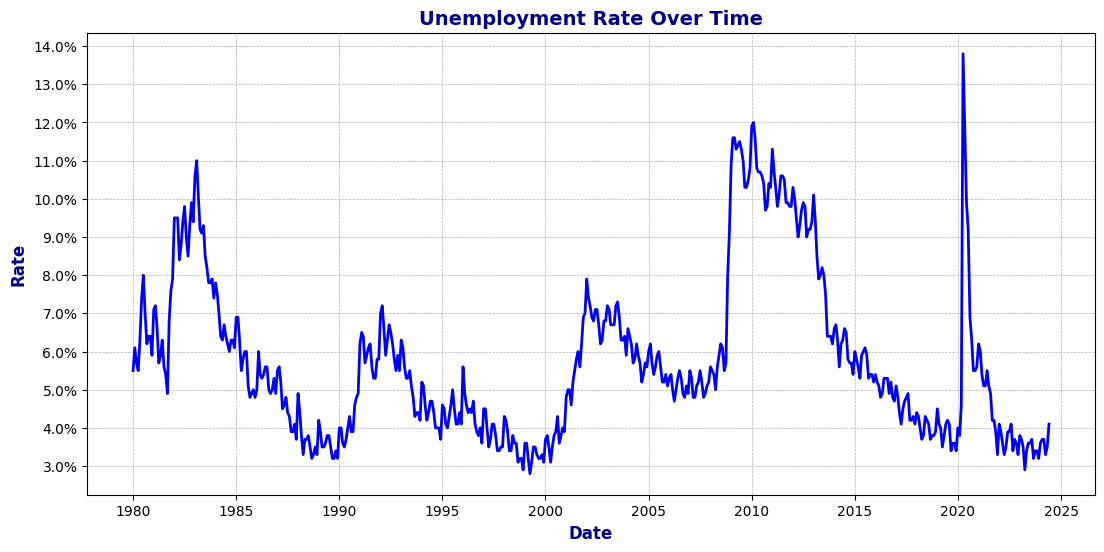

In [420]:
unemployment.head()
plt.figure(figsize=(13, 6))
plt.plot(unemployment['Date'], unemployment['Unemployment Rate(%)'], linewidth=2, linestyle='-', color='blue')
plt.title("Unemployment Rate Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Rate", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(0, 20, 1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig("graphs/unemployment_rate_over_time.png")
plt.plot()

In [434]:
start_end_data = {
    "income": [8350, 60484],
    "house": [100000, 649300],
    "electricity": [0.053, 0.169],
    "gas": [1.131, 3.289],
    "car": [7574, 48000],
    "rent": [255, 1350],
    "min_wage": [2.75, 7.25],
    # "mortgage_rate": [12.85, 6.61],
    "population": [5.9, 10.8]
}
df = pd.DataFrame(start_end_data)
df = df.transpose()
df.columns = [1980, 2023]
df['change'] = (df[2023] - df[1980]) / df[1980] * 100


adjusted_start_end_data = {
    "income": [21020, 60484],
    "house": [100000, 649300],
    "electricity": [0.053, 0.169],
    "gas": [1.131, 3.289],
    "car": [28000, 48000],
    "rent": [255, 1350],
    "min_wage": [2.75, 7.25],
    # "mortgage_rate": [12.85, 6.61],
    "population": [5.9, 10.8]
}
adjusted_df = pd.DataFrame(adjusted_start_end_data)
adjusted_df = adjusted_df.transpose()
adjusted_df.columns = [1980, 2023]
adjusted_df['change'] = (adjusted_df[2023] - adjusted_df[1980]) / adjusted_df[1980] *100
adjusted_df


,1980,2023,change
income,21020.000,60484.000,187.745005
house,100000.000,649300.000,549.300000
electricity,0.053,0.169,218.867925
gas,1.131,3.289,190.804598
car,28000.000,48000.000,71.428571
rent,255.000,1350.000,429.411765
min_wage,2.750,7.250,163.636364
population,5.900,10.800,83.050847


[]

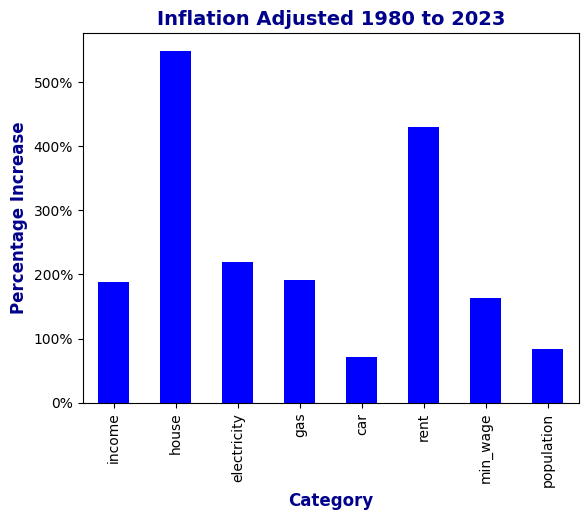

In [430]:
adjusted_df['change'].plot(kind='bar', color='blue')
plt.title("Inflation Adjusted 1980 to 2023", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Percentage Increase", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Category", fontsize=12, fontweight='bold', color='darkblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.savefig("graphs/bar_price_increase.png")
plt.plot()

[]

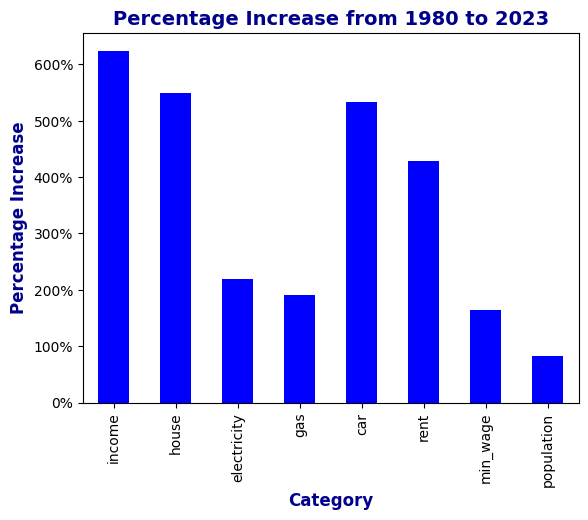

In [436]:

df['change'].plot(kind='bar', color='blue')
plt.title("Percentage Increase from 1980 to 2023", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Percentage Increase", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Category", fontsize=12, fontweight='bold', color='darkblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.savefig("graphs/bar_price_increase.png")
plt.plot()